In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from time import time
from sklearn import metrics
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import log_loss
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [ ]:
pet_dataset = pd.read_csv('balanced_pet_dataset.csv')

<ipython-input-2-75c76a69d200>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  pet_dataset = pd.read_csv('/content/drive/MyDrive/Thesis/balanced_pet_dataset.csv')


In [ ]:
pet_dataset

,pet,age,gender,color,size,description,pid,photos,adopted,description_words,word_count
0,Cat,Adult,Male,Brown_Chocolate,Small,For further information please visit our websi...,41085682,1,Adopted,"['For', 'further', 'information', 'please', 'v...",643
1,Cat,Young,Male,Unknown,Medium,Bart is a sweet and joyful boy who loves to be...,42779556,2,Adopted,"['Bart', 'is', 'a', 'sweet', 'and', 'joyful', ...",1975
2,Dog,Adult,Female,Other,Medium,Wake up every morning to someone who truly L?V...,40922487,5,Adopted,"['Wake', 'up', 'every', 'morning', 'to', 'some...",1963
3,Dog,Baby,Female,Other,Large,Nala is a 9 month old female mix. She is guess...,41787973,6,Adopted,"['Nala', 'is', 'a', '9', 'month', 'old', 'fema...",1558
4,Cat,Baby,Female,Other,Medium,Yuki is a social butterfly with people and wit...,42801248,1,Adopted,"['Yuki', 'is', 'a', 'social', 'butterfly', 'wi...",809
...,...,...,...,...,...,...,...,...,...,...,...
221326,Dog,Adult,Male,Unknown,Medium,"Woof! It's me Moose, a 2 year old Border Colli...",42312550,3,Unadopted,"['Woof', '!', 'It', ""'s"", 'me', 'Moose', ',', ...",3610
221327,Dog,Adult,Male,Unknown,Medium,"Hi there! My name is Zagnut, but my foster mom...",41380802,5,Unadopted,"['Hi', 'there', '!', 'My', 'name', 'is', 'Zagn...",3628
221328,Cat,Young,Female,Unknown,Medium,Please contact Tia (tkocianic@yahoo.com) for m...,39027997,3,Unadopted,"['Please', 'contact', 'Tia', '(', 'tkocianic',...",3621
221329,Dog,Adult,Female,Unknown,Medium,Hello world! My name is Tassels and I am excit...,42083623,3,Unadopted,"['Hello', 'world', '!', 'My', 'name', 'is', 'T...",3596


In [ ]:
X_test = pd.read_csv('/content/drive/MyDrive/Thesis/X_test.csv')
X_train = pd.read_csv('/content/drive/MyDrive/Thesis/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Thesis/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Thesis/y_test.csv')

In [ ]:
X_train = X_train.drop(columns=['Unnamed: 0'])
y_test = y_test.drop(columns=['Unnamed: 0'])
y_train = y_train.drop(columns=['Unnamed: 0'])
X_test = X_test.drop(columns=['Unnamed: 0'])

In [ ]:
label_encoder = LabelEncoder()

y_test['adopted_encoded'] = label_encoder.fit_transform(y_test['adopted'])

y_test['adopted_encoded'] = np.where(y_test['adopted_encoded'] == 0, 1, 0)

y_train['adopted_encoded'] = label_encoder.fit_transform(y_train['adopted'])

y_train['adopted_encoded'] = np.where(y_train['adopted_encoded'] == 0, 1, 0)

y_test = y_test.drop(columns=['adopted'])
y_train = y_train.drop(columns=['adopted'])

In [ ]:
ordinal_encoder = OrdinalEncoder()

X_train['age_encoded'] = ordinal_encoder.fit_transform(X_train[['age']])
X_train['size_encoded'] = ordinal_encoder.fit_transform(X_train[['size']])

X_train = X_train.drop(['age', 'size'], axis=1)

In [ ]:
ordinal_encoder = OrdinalEncoder()

X_test['age_encoded'] = ordinal_encoder.fit_transform(X_test[['age']])
X_test['size_encoded'] = ordinal_encoder.fit_transform(X_test[['size']])

X_test = X_test.drop(['age', 'size'], axis=1)

In [ ]:
# code from: https://datascience.stackexchange.com/questions/71804/how-to-perform-one-hot-encoding-on-multiple-categorical-columns

ohe = OneHotEncoder(sparse_output=False)

Xtrain_encoded = ohe.fit_transform(X_train[['pet', 'gender', 'color']])

X_train_encoded = pd.DataFrame(Xtrain_encoded, columns=ohe.get_feature_names_out(['pet', 'gender', 'color']))

#Extract only the columns that didnt need to be encoded
data_other_cols = X_train.drop(columns=['pet', 'gender', 'color'])

#Concatenate the two dataframes :
X_train_2 = pd.concat([X_train_encoded, data_other_cols], axis=1)



In [ ]:
# code from: https://datascience.stackexchange.com/questions/71804/how-to-perform-one-hot-encoding-on-multiple-categorical-columns

ohe = OneHotEncoder(sparse_output=False)

Xtest_encoded = ohe.fit_transform(X_test[['pet', 'gender', 'color']])

X_test_encoded = pd.DataFrame(Xtest_encoded, columns=ohe.get_feature_names_out(['pet', 'gender', 'color']))

#Extract only the columns that didnt need to be encoded
data_other_cols = X_test.drop(columns=['pet', 'gender', 'color'])

#Concatenate the two dataframes :
X_test_2 = pd.concat([X_test_encoded, data_other_cols], axis=1)


In [ ]:
X_test_2

,pet_Cat,pet_Dog,pet_Rabbit,gender_Female,gender_Male,gender_Mixed,gender_Unknown,color_Black,color_Black_White,color_Brown_Chocolate,...,vector_92,vector_93,vector_94,vector_95,vector_96,vector_97,vector_98,vector_99,age_encoded,size_encoded
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.059053,0.253944,-0.134316,0.352780,0.076132,0.231228,-0.015402,0.585188,2.0,3.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.009155,0.135924,0.012253,0.006966,0.047521,0.012037,-0.279150,0.272248,3.0,2.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.149434,0.141436,0.209824,0.061069,0.200590,0.076650,-0.063295,0.470014,2.0,2.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.041591,0.035745,0.153102,-0.006564,0.100330,0.073430,-0.020734,0.133471,0.0,3.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000257,0.178879,-0.008426,-0.043694,0.184267,0.098949,-0.047755,0.270142,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33173,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.201470,-0.196980,-0.023798,-0.204447,-0.211816,0.056710,-0.080183,0.379047,0.0,2.0
33174,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.123151,0.439655,0.322086,0.126867,0.344908,-0.001791,-0.069777,0.139832,1.0,2.0
33175,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164814,0.062713,0.022912,-0.032528,0.065442,0.042717,-0.110760,0.263868,0.0,3.0
33176,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.068609,0.129991,0.078074,0.067940,0.062951,0.048482,-0.071546,0.215619,1.0,2.0


In [ ]:
print(X_train_2.shape, X_test_2.shape, y_train.shape, y_test.shape)

(188003, 119) (33178, 119) (188003, 1) (33178, 1)


## XGBoost

In [ ]:

xgb = XGBClassifier(random_state=555, device = "cuda")

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=555)

space = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
}

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=space, n_iter=10, scoring='accuracy', cv=kf, verbose=2, random_state=555, return_train_score=True)


In [ ]:
random_search.fit(X_train_2, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best training accuracy: {random_search.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:47:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   1.7s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   1.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   1.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   1.6s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   1.3s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   1.3s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   1.8s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   1.3s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   1.3s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   1.2s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   1.2s
[CV] END ....learning_rate=0

In [ ]:
print(f"Best parameters: {random_search.best_params_}")
print(f"Best training accuracy: {random_search.best_score_}")

Best parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}
Best training accuracy: 0.7656154561303541


In [ ]:
best_xgb_model = random_search.best_estimator_
xgb_predictions = best_xgb_model.predict(X_test_2)
print(f"Test accuracy: {accuracy_score(y_test, xgb_predictions)}")

Test accuracy: 0.7666224606667068


In [ ]:
with open('best_xgb_model.pkl', 'wb') as file:
    pickle.dump(best_xgb_model, file)

results_df = pd.DataFrame(random_search.cv_results_)

results_df.to_csv('/content/drive/MyDrive/Thesis/xgb_random_search_results.csv', index=False)

xgb_predictions_df = pd.DataFrame(xgb_predictions)

xgb_predictions_df.to_csv('/content/drive/MyDrive/Thesis/xgb_predictions.csv', index=False)

In [ ]:
# performance on test set

# accuracy
print(f"Test Accuracy: {accuracy_score(y_test, xgb_predictions)}")

# f1-score
f1 = f1_score(y_test, xgb_predictions)
print(f"F1-Score: {f1}")

# classification report
print(classification_report(y_test, xgb_predictions))


Test Accuracy: 0.7666224606667068
F1-Score: 0.7679304660572457
              precision    recall  f1-score   support

           0       0.76      0.77      0.77     16451
           1       0.77      0.77      0.77     16727

    accuracy                           0.77     33178
   macro avg       0.77      0.77      0.77     33178
weighted avg       0.77      0.77      0.77     33178



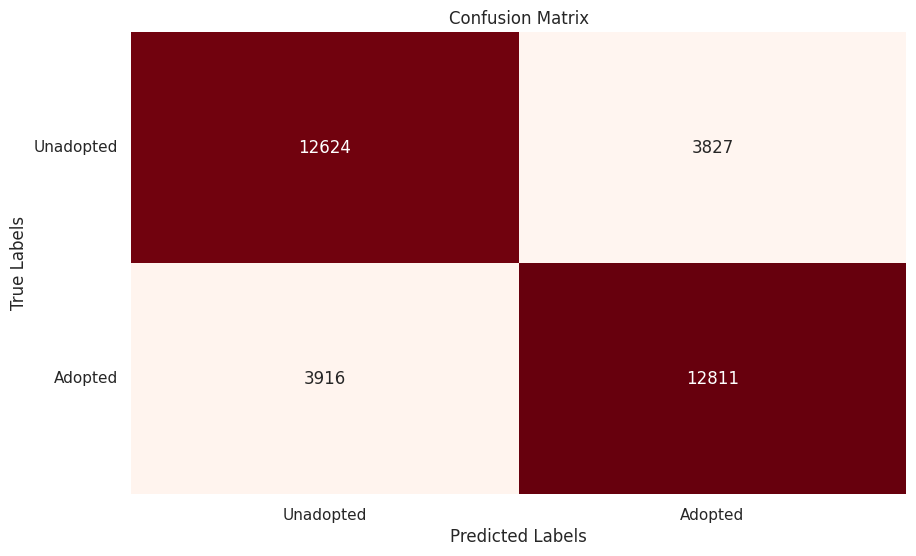

In [ ]:
# code retrieved from: https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap

# plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_predictions)

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(10, 6))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Reds', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

class_labels = ['Unadopted', 'Adopted']
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0, va="center")

plt.show()


Actual Class Counts:
{'Adopted': 16727, 'Unadopted': 16451}
Predicted Class Counts:
{'Adopted': 16638, 'Unadopted': 16540}


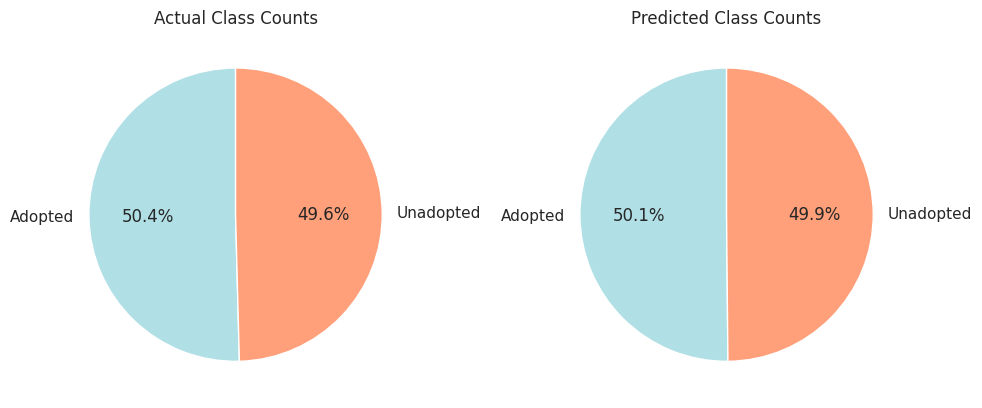

In [ ]:

# visualizing the number of the adoption/no adoption predictions vs the real number

# Actual Class Counts
actual_classes, actual_counts = np.unique(y_test, return_counts=True)
actual_class_counts = dict(zip(['Adopted' if x == 1 else 'Unadopted' for x in actual_classes[::-1]], actual_counts[::-1]))
print("Actual Class Counts:")
print(actual_class_counts)

# Predicted Class Counts
predicted_classes, predicted_counts = np.unique(xgb_predictions, return_counts=True)
predicted_class_counts = dict(zip(['Adopted' if x == 1 else 'Unadopted' for x in predicted_classes[::-1]], predicted_counts[::-1]))
print("Predicted Class Counts:")
print(predicted_class_counts)

# Visualization with Pie Charts
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Pie chart for Actual class counts
ax[0].pie(actual_counts[::-1], labels=actual_class_counts.keys(), autopct='%1.1f%%', startangle=90, colors=['powderblue', 'lightsalmon'])
ax[0].set_title('Actual Class Counts')

# Pie chart for Predicted class counts
ax[1].pie(predicted_counts[::-1], labels=predicted_class_counts.keys(), autopct='%1.1f%%', startangle=90, colors=['powderblue', 'lightsalmon'])
ax[1].set_title('Predicted Class Counts')

plt.tight_layout()
plt.show()


## LightGBM

In [ ]:
print(X_train_2.shape, X_test_2.shape, y_train.shape, y_test.shape)

(188003, 119) (33178, 119) (188003,) (33178,)


In [ ]:
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

In [ ]:
lgbm = LGBMClassifier(objective='binary', random_state=555)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=555)

space = {
    'num_leaves': [10, 50, 70],
    'num_iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1]
}

random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=space, n_iter=10,
                                   scoring='accuracy', cv=kf, verbose=2, random_state=555, return_train_score=True)


In [ ]:
random_search.fit(X_train_2, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=500, num_leaves=70; total time=  24.4s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=500, num_leaves=70; total time=  23.6s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=500, num_leaves=70; total time=  30.8s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.01, num_iterations=500, num_leaves=70; total time=  22.4s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.01, num_iterations=500, num_leaves=70; total time=  22.5s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.1, num_iterations=1000, num_leaves=10; total time=  15.7s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.1, num_iterations=1000, num_leaves=10; total time=  15.4s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.1, num_iterations=1000, num_leaves=10; total time=  15.7s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.1, num_iterations=1000, num_leaves=10; total time=  16.4s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.1, num_iterations=1000, num_leaves=10; total time=  15.9s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.1, num_iterations=500, num_leaves=10; total time=   9.3s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.1, num_iterations=500, num_leaves=10; total time=  10.9s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.1, num_iterations=500, num_leaves=10; total time=  10.3s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.1, num_iterations=500, num_leaves=10; total time=  11.0s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.1, num_iterations=500, num_leaves=10; total time=  12.1s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.05, num_iterations=500, num_leaves=70; total time=  21.2s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.05, num_iterations=500, num_leaves=70; total time=  25.1s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.05, num_iterations=500, num_leaves=70; total time=  23.3s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.05, num_iterations=500, num_leaves=70; total time=  21.1s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.05, num_iterations=500, num_leaves=70; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=1500, num_leaves=50; total time=  56.9s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=1500, num_leaves=50; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=1500, num_leaves=50; total time=  58.8s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.01, num_iterations=1500, num_leaves=50; total time=  54.3s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.01, num_iterations=1500, num_leaves=50; total time=  54.0s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=1500, num_leaves=70; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=1500, num_leaves=70; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=1500, num_leaves=70; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.01, num_iterations=1500, num_leaves=70; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.01, num_iterations=1500, num_leaves=70; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.1, num_iterations=1500, num_leaves=50; total time=  35.5s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.1, num_iterations=1500, num_leaves=50; total time=  34.5s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.1, num_iterations=1500, num_leaves=50; total time=  34.3s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.1, num_iterations=1500, num_leaves=50; total time=  35.0s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.1, num_iterations=1500, num_leaves=50; total time=  35.5s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=1000, num_leaves=70; total time=  42.9s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=1000, num_leaves=70; total time=  42.3s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=1000, num_leaves=70; total time=  42.6s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.01, num_iterations=1000, num_leaves=70; total time=  43.2s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.01, num_iterations=1000, num_leaves=70; total time=  43.0s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=1000, num_leaves=10; total time=  21.2s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=1000, num_leaves=10; total time=  20.3s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.01, num_iterations=1000, num_leaves=10; total time=  21.3s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.01, num_iterations=1000, num_leaves=10; total time=  21.5s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.01, num_iterations=1000, num_leaves=10; total time=  20.8s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.05, num_iterations=1500, num_leaves=10; total time=  23.5s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.05, num_iterations=1500, num_leaves=10; total time=  24.3s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75358, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150402, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501044 -> initscore=0.004175
[LightGBM] [Info] Start training from score 0.004175
[CV] END learning_rate=0.05, num_iterations=1500, num_leaves=10; total time=  24.2s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.05, num_iterations=1500, num_leaves=10; total time=  26.1s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 75359, number of negative: 75044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 150403, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501047 -> initscore=0.004189
[LightGBM] [Info] Start training from score 0.004189
[CV] END learning_rate=0.05, num_iterations=1500, num_leaves=10; total time=  23.6s


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 94198, number of negative: 93805
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25545
[LightGBM] [Info] Number of data points in the train set: 188003, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501045 -> initscore=0.004181
[LightGBM] [Info] Start training from score 0.004181
Best parameters: {'num_leaves': 50, 'num_iterations': 1500, 'learning_rate': 0.1}
Best cross-validation accuracy: 0.7965298406221655


In [ ]:
# Print best parameters and best cross-validation accuracy
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_}")


Best parameters: {'num_leaves': 50, 'num_iterations': 1500, 'learning_rate': 0.1}
Best cross-validation accuracy: 0.7965298406221655


In [ ]:
# Evaluate on the test set
best_lgbm_model = random_search.best_estimator_
lgbm_predictions = best_lgbm_model.predict(X_test_2)
print(f"Test accuracy: {accuracy_score(y_test, lgbm_predictions)}")


Test accuracy: 0.7973657242751221


In [ ]:
with open('best_lgbm_model.pkl', 'wb') as file:
    pickle.dump(best_lgbm_model, file)


results_df = pd.DataFrame(random_search.cv_results_)

results_df.to_csv('/content/drive/MyDrive/Thesis/lgbm_random_search_results.csv', index=False)

lgbm_predictions_df = pd.DataFrame(lgbm_predictions)

lgbm_predictions_df.to_csv('/content/drive/MyDrive/Thesis/lgbm_predictions.csv', index=False)

In [ ]:

f1 = f1_score(y_test, lgbm_predictions)
print(f"F1-Score: {f1}")

print(classification_report(y_test, lgbm_predictions))

F1-Score: 0.798392659009806
              precision    recall  f1-score   support

           0       0.79      0.80      0.80     16451
           1       0.80      0.80      0.80     16727

    accuracy                           0.80     33178
   macro avg       0.80      0.80      0.80     33178
weighted avg       0.80      0.80      0.80     33178



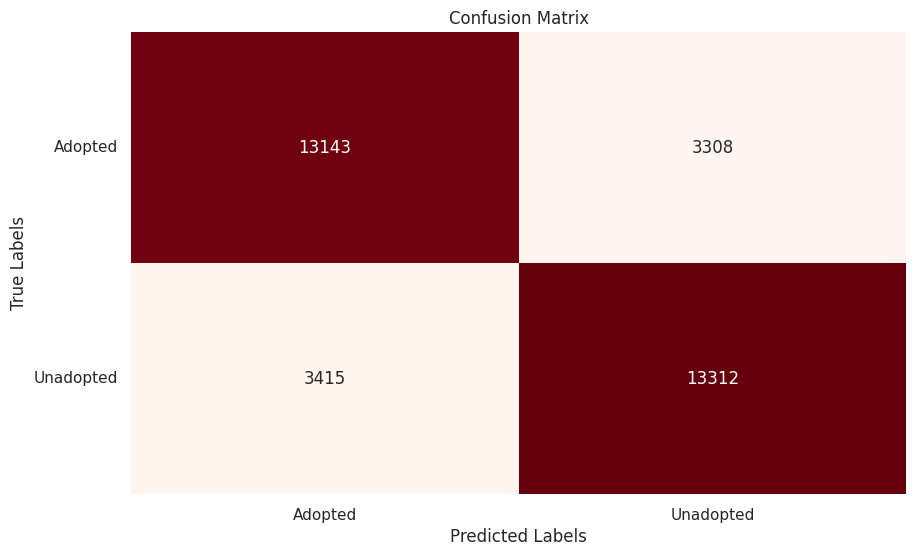

In [ ]:
# code retrieved from: https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap

# plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, lgbm_predictions)

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(10, 6))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Reds', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

class_labels = ['Adopted', 'Unadopted']
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0, va="center")

plt.show()

Actual Class Counts:
{'Adopted': 16727, 'Unadopted': 16451}
Predicted Class Counts:
{'Adopted': 16620, 'Unadopted': 16558}


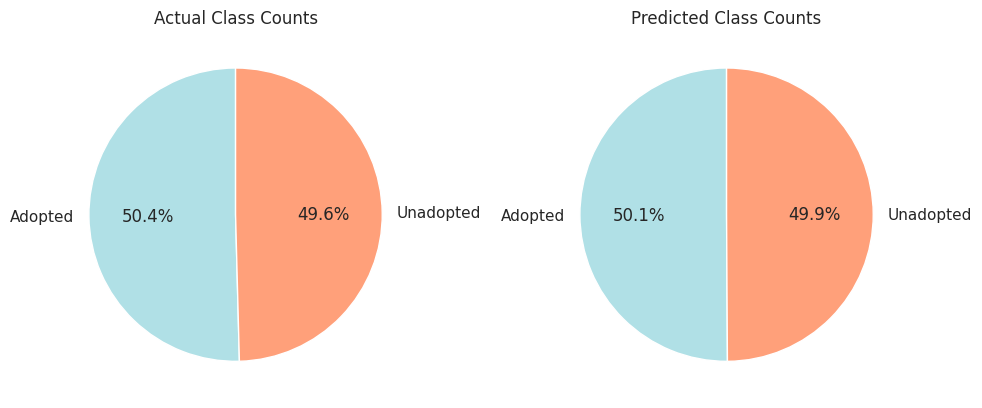

In [ ]:
# visualizing the number of the adoption/no adoption predictions vs the real number

# Actual Class Counts
actual_classes, actual_counts = np.unique(y_test, return_counts=True)

actual_class_counts = dict(zip(['Adopted' if x == 1 else 'Unadopted' for x in actual_classes[::-1]], actual_counts[::-1]))
print("Actual Class Counts:")
print(actual_class_counts)

# Predicted Class Counts
predicted_classes, predicted_counts = np.unique(lgbm_predictions, return_counts=True)

predicted_class_counts = dict(zip(['Adopted' if x == 1 else 'Unadopted' for x in predicted_classes[::-1]], predicted_counts[::-1]))
print("Predicted Class Counts:")
print(predicted_class_counts)

# Visualization with Pie Charts
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Pie chart for Actual class counts
ax[0].pie(actual_counts[::-1], labels=actual_class_counts.keys(), autopct='%1.1f%%', startangle=90, colors=['powderblue', 'lightsalmon'])
ax[0].set_title('Actual Class Counts')

# Pie chart for Predicted class counts
ax[1].pie(predicted_counts[::-1], labels=predicted_class_counts.keys(), autopct='%1.1f%%', startangle=90, colors=['powderblue', 'lightsalmon'])
ax[1].set_title('Predicted Class Counts')

plt.tight_layout()
plt.show()

## GBM Classifier

In [ ]:
gbm = GradientBoostingClassifier(random_state=555)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=555)

space = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150]
}

random_search = RandomizedSearchCV(estimator=gbm, param_distributions=space, n_iter=10,
                                   scoring='accuracy', cv=kf, verbose=2, random_state=555, return_train_score=True)


In [ ]:
random_search.fit(X_train_2, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=16.0min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=16.1min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=16.2min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=16.4min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=16.3min
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time= 8.7min
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time= 8.8min
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time= 8.8min
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time= 8.9min
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time= 9.0min
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time= 5.5min
[CV] END ....learning_rate=0.1, max_depth=3, n_e

In [ ]:
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_}")


Best parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}
Best cross-validation accuracy: 0.5058823529411766


In [ ]:
best_gbm_model = random_search.best_estimator_
gbm_predictions = best_gbm_model.predict(X_test_2)
print(f"Test accuracy: {accuracy_score(y_test, gbm_predictions)}")


Test accuracy: 0.7669238652118874


In [ ]:
with open('best_gbm_model.pkl', 'wb') as file:
    pickle.dump(best_gbm_model, file)

results_df = pd.DataFrame(random_search.cv_results_)

results_df.to_csv('/content/drive/MyDrive/Thesis/gbm_random_search_results.csv', index=False)

gbm_predictions_df = pd.DataFrame(gbm_predictions)

gbm_predictions_df.to_csv('/content/drive/MyDrive/Thesis/gbm_predictions.csv', index=False)

In [ ]:
f1 = f1_score(y_test, gbm_predictions)
print(f"F1-Score: {f1}")

print(classification_report(y_test, gbm_predictions))

F1-Score: 0.7685631341094783
              precision    recall  f1-score   support

           0       0.76      0.77      0.77     16451
           1       0.77      0.77      0.77     16727

    accuracy                           0.77     33178
   macro avg       0.77      0.77      0.77     33178
weighted avg       0.77      0.77      0.77     33178



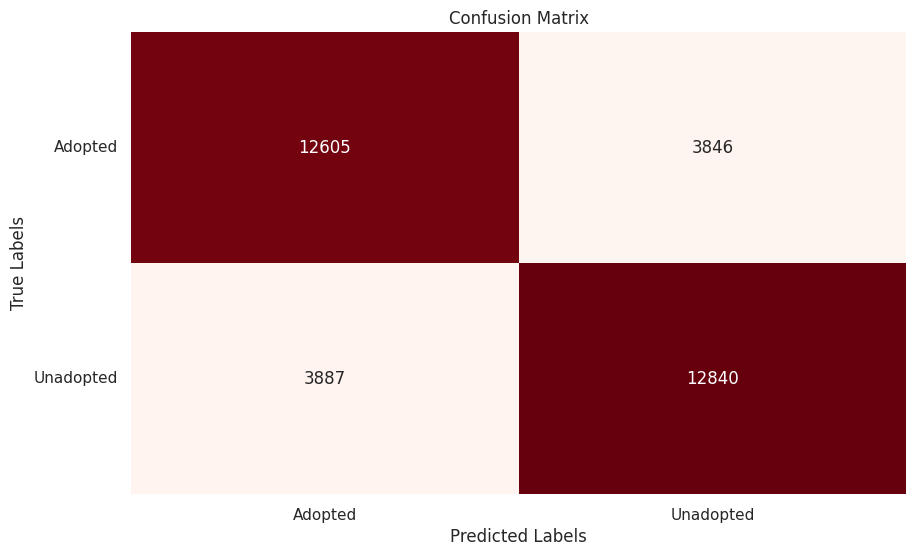

In [ ]:
# code retrieved from: https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap

# plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, gbm_predictions)

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(10, 6))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Reds', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

class_labels = ['Adopted', 'Unadopted']
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0, va="center")

plt.show()

Actual Class Counts:
{'Adopted': 16727, 'Unadopted': 16451}
Predicted Class Counts:
{'Adopted': 16686, 'Unadopted': 16492}


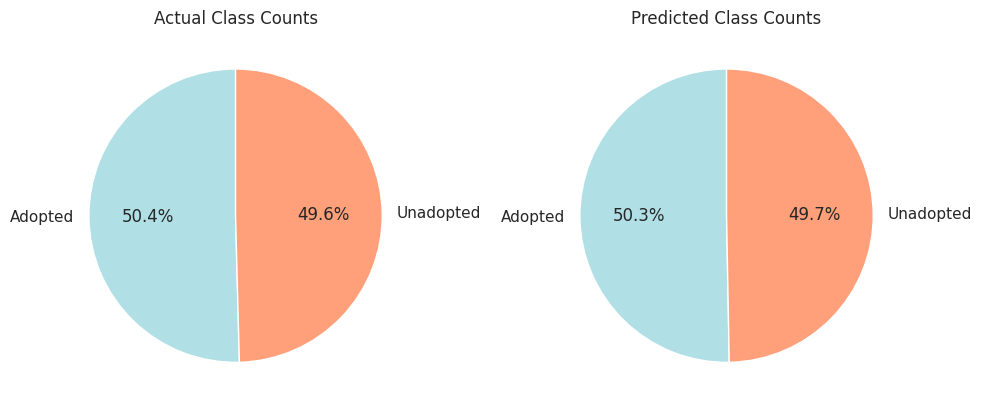

In [ ]:
# visualizing the number of the adoption/no adoption predictions vs the real number

# Actual Class Counts
actual_classes, actual_counts = np.unique(y_test, return_counts=True)
actual_class_counts = dict(zip(['Adopted' if x == 1 else 'Unadopted' for x in actual_classes[::-1]], actual_counts[::-1]))
print("Actual Class Counts:")
print(actual_class_counts)

# Predicted Class Counts
predicted_classes, predicted_counts = np.unique(gbm_predictions, return_counts=True)
predicted_class_counts = dict(zip(['Adopted' if x == 1 else 'Unadopted' for x in predicted_classes[::-1]], predicted_counts[::-1]))
print("Predicted Class Counts:")
print(predicted_class_counts)

# Visualization with Pie Charts
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Pie chart for Actual class counts
ax[0].pie(actual_counts[::-1], labels=actual_class_counts.keys(), autopct='%1.1f%%', startangle=90, colors=['powderblue', 'lightsalmon'])
ax[0].set_title('Actual Class Counts')

# Pie chart for Predicted class counts
ax[1].pie(predicted_counts[::-1], labels=predicted_class_counts.keys(), autopct='%1.1f%%', startangle=90, colors=['powderblue', 'lightsalmon'])
ax[1].set_title('Predicted Class Counts')

plt.tight_layout()
plt.show()

## Rec and pres

In [ ]:

y_test = pd.read_csv('/content/drive/MyDrive/Thesis/y_test.csv')
predictions = pd.read_csv('/content/drive/MyDrive/Thesis/xgb_predictions.csv')

label_encoder = LabelEncoder()

y_test['adopted_encoded'] = label_encoder.fit_transform(y_test['adopted'])

y_test['adopted_encoded'] = np.where(y_test['adopted_encoded'] == 0, 1, 0)

print(f1_score(y_test['adopted_encoded'], predictions['0'], pos_label=1),
recall_score(y_test['adopted_encoded'], predictions['0'], pos_label=1),
precision_score(y_test['adopted_encoded'], predictions['0'], pos_label=1))

0.7679304660572457 0.7658874872959885 0.7699843731217695


In [ ]:
y_test = pd.read_csv('/content/drive/MyDrive/Thesis/y_test.csv')
predictions = pd.read_csv('/content/drive/MyDrive/Thesis/gbm_predictions.csv')

label_encoder = LabelEncoder()

y_test['adopted_encoded'] = label_encoder.fit_transform(y_test['adopted'])

y_test['adopted_encoded'] = np.where(y_test['adopted_encoded'] == 0, 1, 0)

print(f1_score(y_test['adopted_encoded'], predictions['0'], pos_label=1),
recall_score(y_test['adopted_encoded'], predictions['0'], pos_label=1),
precision_score(y_test['adopted_encoded'], predictions['0'], pos_label=1))

0.7685631341094783 0.7676212112154003 0.7695073714491191


In [ ]:
y_test = pd.read_csv('/content/drive/MyDrive/Thesis/y_test.csv')
predictions = pd.read_csv('/content/drive/MyDrive/Thesis/lgbm_predictions.csv')

label_encoder = LabelEncoder()

y_test['adopted_encoded'] = label_encoder.fit_transform(y_test['adopted'])

y_test['adopted_encoded'] = np.where(y_test['adopted_encoded'] == 0, 1, 0)

print(f1_score(y_test['adopted_encoded'], predictions['0'], pos_label=1),
recall_score(y_test['adopted_encoded'], predictions['0'], pos_label=1),
precision_score(y_test['adopted_encoded'], predictions['0'], pos_label=1))

0.798392659009806 0.7958390625934119 0.8009626955475331
